<a href="https://colab.research.google.com/github/Hamza-t/Language-Identification/blob/main/Data_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hello!
In this notebook, we will apply the AI stuff to our data to predict the langage of the text.
*   Our task is a text multilabel classification, there is many methods :
1.  the old-fashioned Bag-of-Words (with Tf-Idf or countvector)
2.  the famous Word Embedding (with Word2Vec)
3.  the cutting edge Language models (with BERT).


**In this notebook, we will use the first and the third methods**

**The general process :**
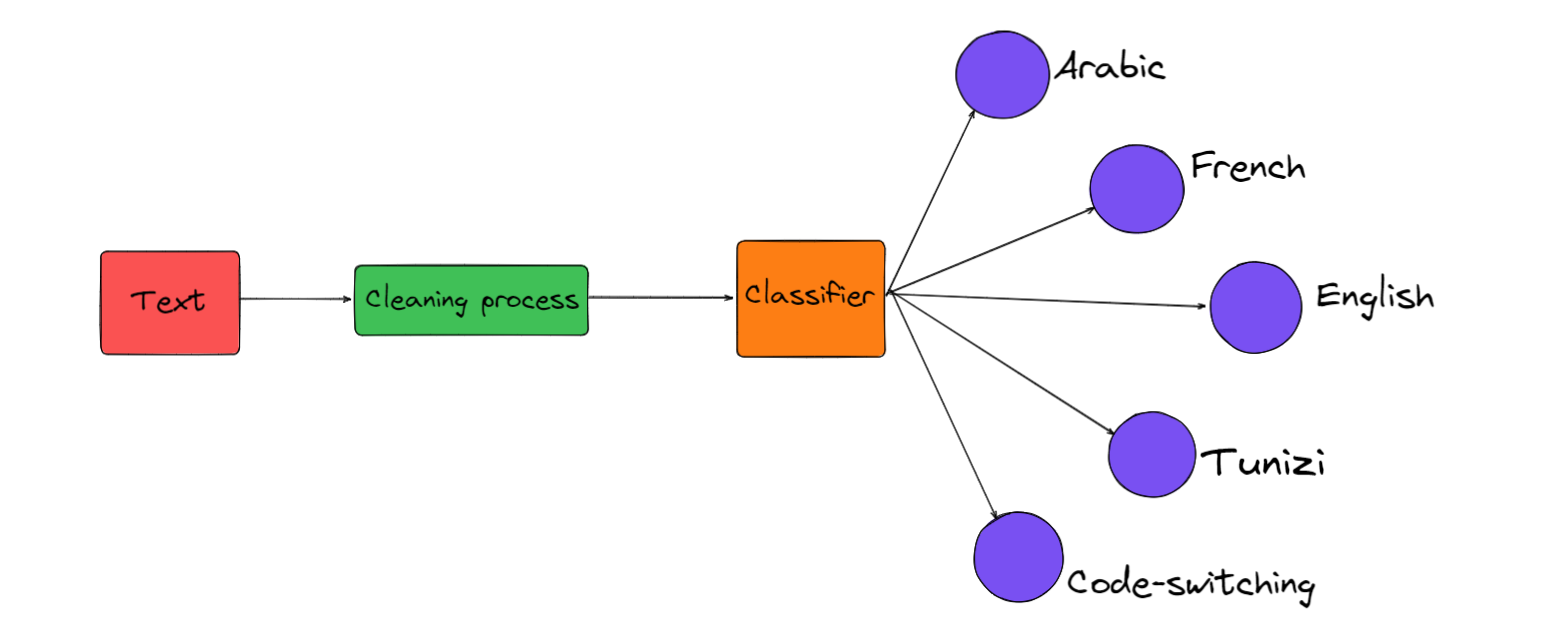

In [ ]:
#Import data file 
#drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#verify the path
folder_path = "/content/drive/MyDrive/My_work/NLP-Project-INSAT"
!ls "/content/drive/MyDrive/My_work/NLP-Project-INSAT"

 cleaned_data.csv	   Data_modeling.ipynb	     'General Data'
'Data augmentation'	   Data_Preparation.ipynb     model.ipynb
 Data_Augmentation.ipynb   Data_validation.ipynb      prepared_data.csv
 Data_cleaning.ipynb	   Data_visualization.ipynb   to_model_data.csv
'data collection '	   final_data.csv


In [ ]:
##assign data path 
data_path = folder_path + "/" + "to_model_data.csv"

In [ ]:
#read data
import pandas as pd
data = pd.read_csv(data_path)
data = data[["text","label"]]
data.head()

,text,label
0,ana fil ghorba w sout el athan ahla haja aijbi...,3
1,man eheb rasoule mohamed,3
2,rabi yerhmou sofiane chaari,3
3,rabi yarahmak ya sbouai wou yarham kol om mita,3
4,merci beaucoup salime,1


In [ ]:
#return the correct label : the langauge name:
def label(x):
  if x == 0 : return 'Arabic'
  elif x==1 : return 'French'
  elif x ==2 : return 'English'
  elif x == 3 : return 'Tunizi'
  else : return 'CS'

##Using the old-fashioned Bag-of-Words (with Tf-Idf or countvector) 🧯

* The text feature extraction methods will be tf-idf and Count-Vectorization
* The classifiers will be Stochastic Gradient Descent and naive_bayes

In [ ]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, linear_model, metrics

In [ ]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(data, test_size=0.3)
## get target
X_train = dtf_train['text'].astype('str').values
y_train = dtf_train["label"].values
X_test = dtf_test['text'].astype('str').values
y_test = dtf_test["label"].values

In [ ]:
## Count (classic BoW)
count_vectorizer = feature_extraction.text.CountVectorizer(max_features=100000, ngram_range=(1,2), encoding='utf-8')

## Tf-Idf (advanced variant of BoW)
tf_idf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100000, ngram_range=(1,2), encoding='utf-8')

In [ ]:
NBclassifier = naive_bayes.MultinomialNB()
SGDclassifer = linear_model.SGDClassifier(loss="modified_huber")

###A- Count vectorizer

In [ ]:
corpus = dtf_train["text"].astype('str').values
count_vectorizer.fit(corpus)
X_train = count_vectorizer.transform(corpus)
dic_vocabulary = count_vectorizer.vocabulary_

#####1- Naive bayes

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", count_vectorizer),  
                           ("classifier", NBclassifier)])  
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.9
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1236
           1       0.91      0.92      0.92      1190
           2       0.96      1.00      0.98      1097
           3       0.84      0.93      0.88      1313
           4       0.71      0.54      0.61       750

    accuracy                           0.90      5586
   macro avg       0.88      0.87      0.87      5586
weighted avg       0.89      0.90      0.89      5586



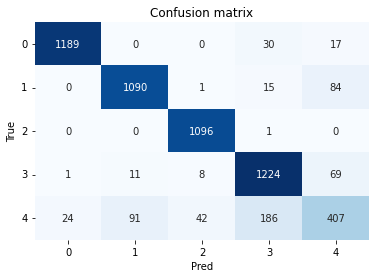

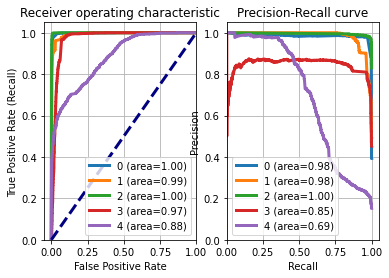

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

#####2- Stochastic Gradient Descent

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", count_vectorizer),  
                           ("classifier", SGDclassifer)])  
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.9
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1236
           1       0.89      0.98      0.93      1190
           2       0.96      0.99      0.98      1097
           3       0.86      0.88      0.87      1313
           4       0.75      0.60      0.67       750

    accuracy                           0.90      5586
   macro avg       0.89      0.88      0.88      5586
weighted avg       0.90      0.90      0.90      5586



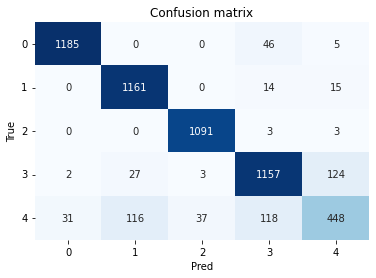

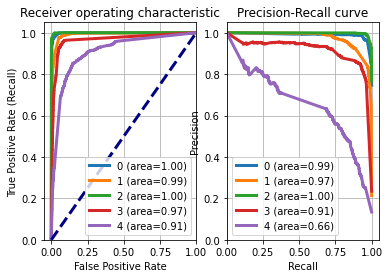

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

###B- Tf-idf Vectorizer

In [ ]:
corpus = dtf_train["text"].astype('str').values
tf_idf_vectorizer.fit(corpus)
X_train = tf_idf_vectorizer.transform(corpus)
dic_vocabulary = tf_idf_vectorizer.vocabulary_

#####1- Naive bayes

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", tf_idf_vectorizer),  
                           ("classifier", NBclassifier)])  
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.9
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1236
           1       0.88      0.97      0.93      1190
           2       0.95      1.00      0.97      1097
           3       0.81      0.98      0.88      1313
           4       0.93      0.35      0.50       750

    accuracy                           0.90      5586
   macro avg       0.91      0.85      0.85      5586
weighted avg       0.90      0.90      0.88      5586



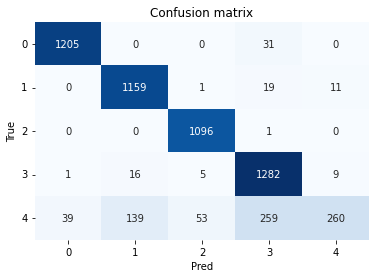

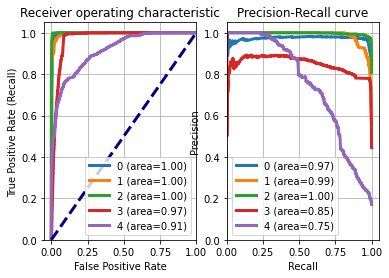

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

#####2- Stochastic Gradient Descent

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", tf_idf_vectorizer),  
                           ("classifier", SGDclassifer)])  
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1236
           1       0.93      0.97      0.95      1190
           2       0.98      0.99      0.98      1097
           3       0.83      0.93      0.87      1313
           4       0.81      0.59      0.68       750

    accuracy                           0.91      5586
   macro avg       0.90      0.89      0.89      5586
weighted avg       0.91      0.91      0.91      5586



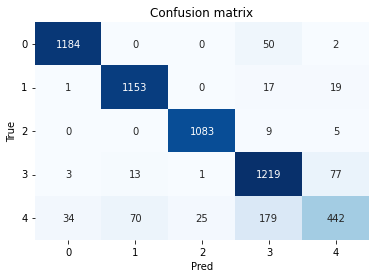

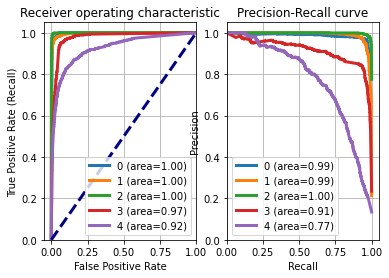

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

##Using the cutting edge Language models (with BERT) 🙂

* In order to complete a text classification task, you can use BERT in 3 different ways:

1. train it all from scratches and use it as classifier.
2. Extract the word embeddings and use them in an embedding layer (like I did with Word2Vec).
3. Fine-tuning the pre-trained model (transfer learning).

**We are going with the latter and do transfer learning from a pre-trained lighter version of BERT, called Distil-BERT (66 million of parameters instead of 110 million!).**

* Then! we will going to build the deep learning model with transfer learning from the pre-trained BERT. Basically, we will going to summarize the output of BERT into one vector with Average Pooling and then add two final Dense layers to predict the probability of each langages.

In [ ]:
!pip install transformers

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(data, test_size=0.3)
## get target
X_train = dtf_train['text'].astype('str').values
y_train = dtf_train["label"].values
X_test = dtf_test['text'].astype('str').values
y_test = dtf_test["label"].values

In [ ]:
import transformers
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
## # generate the input IDs and attention mask in tensor format

#The train data 

idx = []
attn_mask = []
for i in dtf_train['text']:# Encode the sentence
  idx.append(tokenizer.encode_plus(
    text=str(i),  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    #return_attention_mask = True,  # Generate the attention mask
    #return_tensors = 'pt',  # ask the function to return PyTorch tensors
  )['input_ids'])
  attn_mask.append(tokenizer.encode_plus(
    text=str(i),  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    #return_attention_mask = True,  # Generate the attention mask
    #return_tensors = 'pt',  # ask the function to return PyTorch tensors
  )['attention_mask'])

# Get the input IDs and attention mask in tensor format
#input_ids = encoded['input_ids']
#attn_mask = encoded['attention_mask'] 

In [ ]:
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(attn_mask, dtype='int32')] 

In [ ]:
#The test data 
## # generate the input IDs and attention mask in tensor format 

idx1 = []
attn_mask1 = []
for i in dtf_test['text']:# Encode the sentence
  idx1.append(tokenizer.encode_plus(
    text=str(i),  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    #return_attention_mask = True,  # Generate the attention mask
    #return_tensors = 'pt',  # ask the function to return PyTorch tensors
  )['input_ids'])
  attn_mask1.append(tokenizer.encode_plus(
    text=str(i),  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 64,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    #return_attention_mask = True,  # Generate the attention mask
    #return_tensors = 'pt',  # ask the function to return PyTorch tensors
  )['attention_mask'])



In [ ]:
## feature matrix
X_test = [np.asarray(idx1, dtype='int32'), 
           np.asarray(attn_mask1, dtype='int32')] 

In [ ]:
## inputs
idx = layers.Input((64), dtype="int32", name="input_idx")
masks = layers.Input((64), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)

config.output_hidden_states = False

nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 64, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
#training 
training = model.fit(x=X_train, y=y_train, batch_size=32, 
                     epochs=2, shuffle=True, verbose=1, 
                     validation_split=0.3)

Epoch 1/2
286/286 [==============================] - 1401s 5s/step - loss: 0.2832 - accuracy: 0.9016 - val_loss: 0.2206 - val_accuracy: 0.9105
Epoch 2/2
286/286 [==============================] - 1375s 5s/step - loss: 0.1864 - accuracy: 0.9282 - val_loss: 0.2006 - val_accuracy: 0.9248


In [ ]:
predicted_prob = model.predict(X_test)

175/175 [==============================] - 560s 3s/step


In [ ]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

Accuracy: 0.93
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1262
           1       0.97      0.96      0.96      1140
           2       0.99      0.99      0.99      1063
           3       0.86      0.97      0.91      1381
           4       0.87      0.62      0.72       740

    accuracy                           0.93      5586
   macro avg       0.93      0.91      0.91      5586
weighted avg       0.93      0.93      0.93      5586



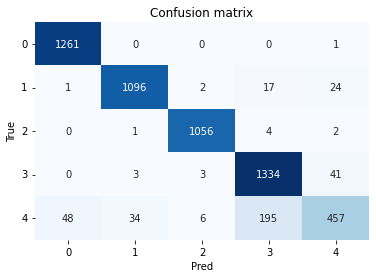

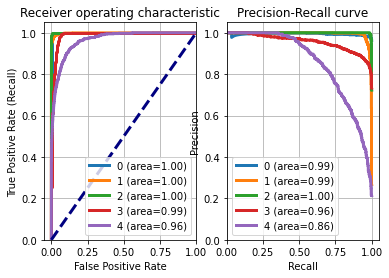

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
#save the model 
model.save("bert_model_.h5") 

## end!